In [1]:
import glob
import ast
import os, re
from collections import defaultdict
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
pattern = "./consolidated cracks/*.txt"
rows = []

DATE_RE = re.compile(r"^\d{4}-\d{2}-\d{2}$")

In [3]:

for filepath in sorted(glob.glob(pattern)):
    filename = os.path.basename(filepath)
    date_str = filename.replace(".txt", "")
    year = date_str.split("-")[0]

    # Read file
    with open(filepath, "r") as f:
        file_content = f.read().strip()

    # Parse safely
    try:
        cracks_dict = ast.literal_eval(file_content)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    # Flatten cracks into rows
    for crack_name, coords_list in cracks_dict.items():
        for lat, lon in coords_list:
            rows.append([year, date_str, crack_name, lat, lon])

# Create DataFrame
df = pd.DataFrame(rows, columns=["year", "date", "crack", "lat", "lon"])

print(df.head())
print(f"Total rows: {len(df)}")

   year        date    crack        lat         lon
0  2014  2014-05-19  Crack 1  67.010664 -162.132102
1  2014  2014-05-19  Crack 1  67.008640 -162.129449
2  2014  2014-05-19  Crack 1  67.006616 -162.126797
3  2014  2014-05-19  Crack 1  67.004592 -162.124146
4  2014  2014-05-19  Crack 1  67.001028 -162.129183
Total rows: 4248


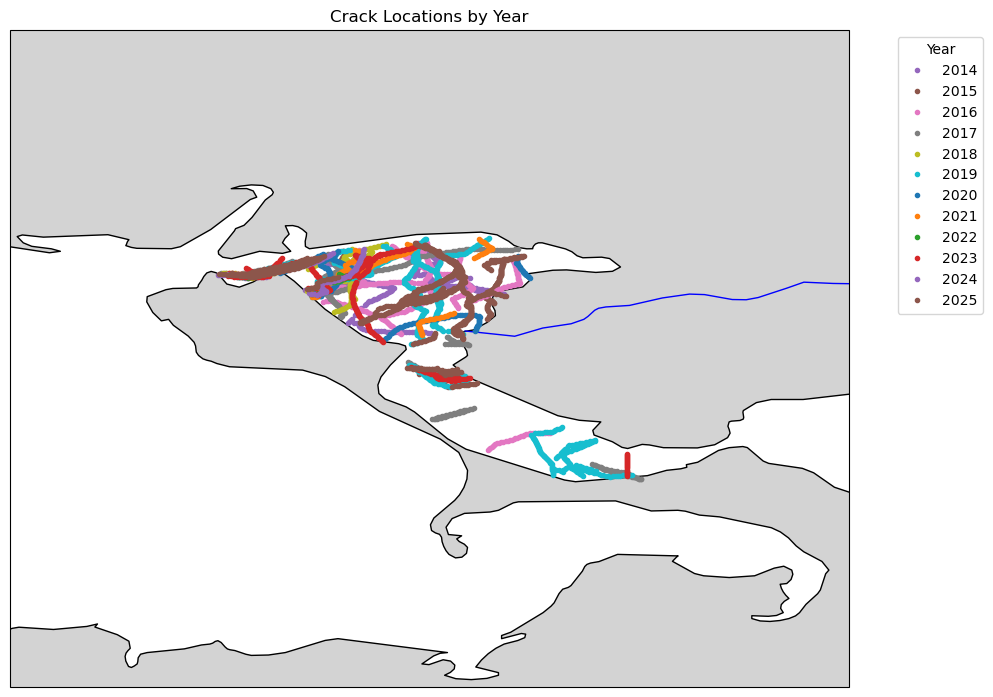

In [4]:
fig = plt.figure(figsize=(10, 8))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)

# Add basic map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='blue')

# Optional: zoom to bounding box around all points
all_lats = df["lat"]
all_lons = df["lon"]
ax.set_extent([min(all_lons)-0.5, max(all_lons)+0.5, min(all_lats)-0.5, max(all_lats)+0.5], crs=ccrs.PlateCarree())

colors = plt.cm.tab10.colors  # 10 distinct colors for up to 10 years
grouped = df.groupby(["year", "crack"])

# Track which years we've labeled to avoid duplicate legend entries
labeled_years = set()

for (year, crack), group in grouped:
    color = colors[int(year) % len(colors)]  # color by year
    lats = group["lat"].tolist()
    lons = group["lon"].tolist()

    # Add label only for the first occurrence of the year
    label = str(year) if year not in labeled_years else ""
    ax.plot(lons, lats, marker=".", linestyle="", color=color, label=label)

    labeled_years.add(year)

# Add legend and labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Crack Locations by Year")
ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
import math 

def segment_bearing_deg(lat1, lon1, lat2, lon2):
    """Initial great-circle bearing from (lat1,lon1) to (lat2,lon2), in [0,360)."""
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δλ = math.radians(lon2 - lon1)
    x = math.sin(Δλ) * math.cos(φ2)
    y = math.cos(φ1) * math.sin(φ2) - math.sin(φ1) * math.cos(φ2) * math.cos(Δλ)
    θ = math.degrees(math.atan2(x, y))
    return (θ + 360.0) % 360.0

def axial_mean_orientation_deg(bearings_deg, weights):
    """
    Length-weighted axial (0≡180) mean of bearings (in degrees).
    Returns angle in [0,180).
    """
    # Double the angles for axial data, average on the circle, then halve.
    ang2 = np.radians(2.0 * np.asarray(bearings_deg))
    w = np.asarray(weights, dtype=float)
    C = np.sum(w * np.cos(ang2))
    S = np.sum(w * np.sin(ang2))
    mean2 = math.atan2(S, C)            # in [-π, π]
    mean_axial = math.degrees(0.5 * mean2)
    if mean_axial < 0:
        mean_axial += 180.0
    return mean_axial

In [6]:
from geopy import distance

grouped = df.groupby(["date", "crack"])
rows = []

for (date, crack), group in grouped:
    lats = group["lat"].tolist()
    lons = group["lon"].tolist()

    length = 0
    segment_lengths = []
    segment_bearings = []

    for i in range(1, len(lats)):
        p1 = (lats[i-1], lons[i-1])
        p2 = (lats[i], lons[i])
        length += abs(distance.distance(p1,p2).km)
        segment_lengths.append(abs(distance.distance(p1,p2).km))
        segment_bearings.append(segment_bearing_deg(p1[0], p1[1], p2[0], p2[1]))
    bearings = segment_bearings
    rows.append([date, crack, length, bearings])

lo = pd.DataFrame(rows, columns=["date", "crack", "length", "bearings"])
print(lo)
    



           date    crack     length  \
0    2014-05-19  Crack 1  25.220296   
1    2014-05-19  Crack 2   9.604793   
2    2014-05-19  Crack 3  12.397510   
3    2014-05-19  Crack 4   7.437702   
4    2014-05-19  Crack 5   4.296533   
..          ...      ...        ...   
101  2025-06-09  Crack 4   5.295195   
102  2025-06-09  Crack 5   6.318529   
103  2025-06-09  Crack 6   5.515795   
104  2025-06-09  Crack 7  10.947978   
105  2025-06-09  Crack 8   2.824965   

                                              bearings  
0    [152.89189115832357, 152.89454600640966, 152.8...  
1    [99.7300956415271, 99.73721316263214, 202.7489...  
2    [300.6194660987184, 300.61354243242215, 300.60...  
3    [129.33432644995577, 129.33921581711172, 129.3...  
4    [212.779282512309, 212.7756437752083, 212.7720...  
..                                                 ...  
101  [65.69241290935474, 65.69769825862221, 65.7029...  
102  [243.24436193137262, 243.23916511516182, 243.2...  
103  [53.258942507

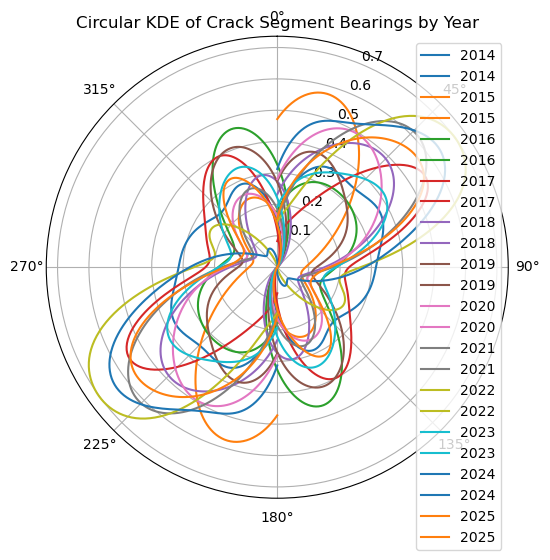

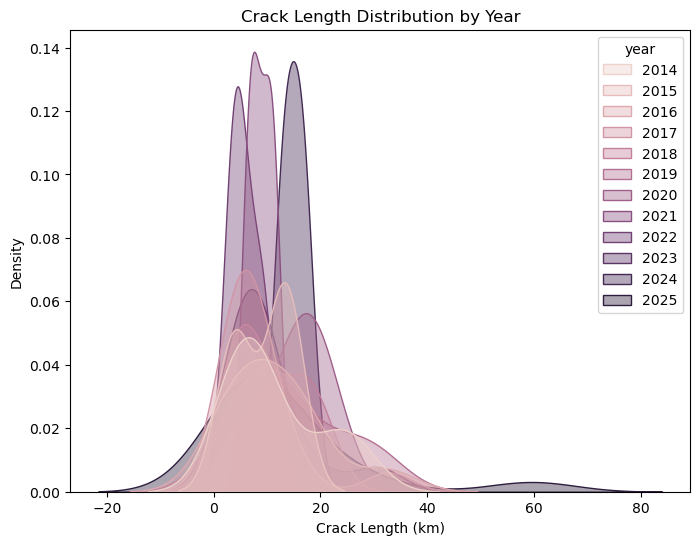

In [7]:
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np

# Assuming lo DataFrame has ["date", "crack", "length", "bearings"]
lo["year"] = pd.to_datetime(lo["date"]).dt.year

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
colors = plt.cm.tab10.colors

for i, (year, group) in enumerate(lo.groupby("year")):
    bearings = np.concatenate(group["bearings"].values)  # flatten lists
    bearings_half = bearings % 180  # map to [0,180)
    bearings_rad = np.radians(bearings_half)

    # KDE
    kde = gaussian_kde(bearings_rad)
    theta = np.linspace(0, 2*np.pi, 360)
    density = kde(theta)

    ax.plot(theta, density, color=colors[i % len(colors)], label=str(year))
    ax.plot(theta+np.pi, density, color=colors[i % len(colors)], label=str(year))

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("Circular KDE of Crack Segment Bearings by Year")
ax.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(data=lo, x="length", hue="year", fill=True, common_norm=False, alpha=0.4)
plt.xlabel("Crack Length (km)")
plt.ylabel("Density")
plt.title("Crack Length Distribution by Year")
plt.show()


In [8]:

import xarray as xr
import numpy as np

# Open your three datasets
ds1 = xr.open_dataset("era5_2023_2025_06.grib", engine="cfgrib")
ds2 = xr.open_dataset("era5_2014_2023_05.grib", engine="cfgrib")
ds3 = xr.open_dataset("era5_2014_05.grib", engine="cfgrib")

# Concatenate along time dimension
ds = xr.concat([ds1, ds2, ds3], dim="time")

# Make sure time is sorted (important if ranges overlap)
ds = ds.sortby("time")

# Extract components
u = ds["u10"]
v = ds["v10"]

# Latitude weights
weights = np.cos(np.radians(ds["latitude"]))
weights.name = "weights"

# Weighted spatial mean, then resample to daily mean
u_daily = u.weighted(weights).mean(dim=("latitude", "longitude")).resample(time="1D").mean()
v_daily = v.weighted(weights).mean(dim=("latitude", "longitude")).resample(time="1D").mean()

# Convert to primary wind direction (degrees, meteorological convention)
primary_dir = (180 + np.degrees(np.arctan2(u_daily, v_daily))) % 360

# Put in dataframe
primary_dir = primary_dir.to_dataframe(name="primary_wind_dir_deg")

print(primary_dir)
#print("Number of daily values:", len(primary_dir))



/Users/makov/miniconda3/envs/subzero/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/makov/miniconda3/envs/subzero/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it w

            number   step  surface  primary_wind_dir_deg
time                                                    
2014-05-01       0 0 days      0.0            161.466999
2014-05-02       0 0 days      0.0            189.458943
2014-05-03       0 0 days      0.0            330.206988
2014-05-04       0 0 days      0.0            264.467802
2014-05-05       0 0 days      0.0            224.773921
...            ...    ...      ...                   ...
2025-05-27       0 0 days      0.0            290.451441
2025-05-28       0 0 days      0.0            312.996099
2025-05-29       0 0 days      0.0            333.625556
2025-05-30       0 0 days      0.0            269.118035
2025-05-31       0 0 days      0.0            127.042325

[4049 rows x 4 columns]


Final array info: (372,) NaNs: 0


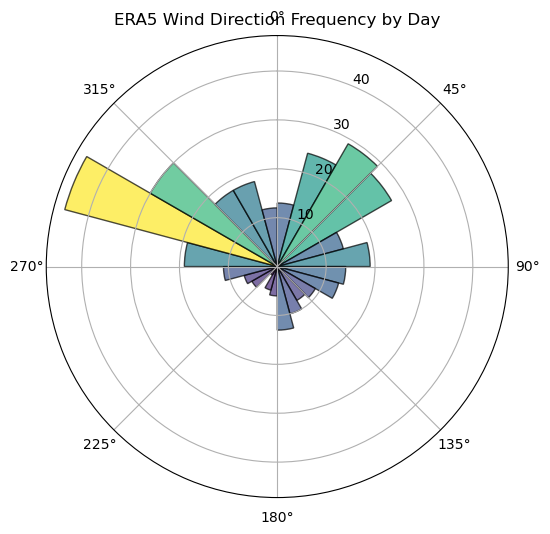

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
colors = plt.cm.tab10.colors

primary_dir = primary_dir.copy()
primary_dir.index = pd.to_datetime(primary_dir.index)

all_angles = []

for date in primary_dir.index:
    wind_angle_deg = primary_dir.loc[date, "primary_wind_dir_deg"]
    if pd.isna(wind_angle_deg):
        continue

    wind_angle = np.radians(wind_angle_deg)

    # ensure numeric
    if np.isfinite(wind_angle):
        all_angles.append(wind_angle)

# convert list to numpy array
all_angles = np.array(all_angles)
print("Final array info:", all_angles.shape, "NaNs:", np.isnan(all_angles).sum())

# Define histogram parameters
n_bins = 24  # 15 degrees per bin
bins = np.linspace(0, 2*np.pi, n_bins + 1)

counts, _ = np.histogram(all_angles, bins=bins)
width = 2 * np.pi / n_bins

bars = ax.bar(
    bins[:-1], counts,
    width=width,
    align='edge',
    color=colors[0],
    edgecolor='k',
    alpha=0.7
)

# Optional: color scale by frequency
for bar, count in zip(bars, counts):
    bar.set_facecolor(plt.cm.viridis(count / counts.max() if counts.max() > 0 else 0))

# formatting
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("ERA5 Wind Direction Frequency by Day", va='bottom')

plt.show()




[0.64115813 0.64120447 0.6412508  ... 4.43929514 4.43929708 4.43929902]
Final array info: (5772,) NaNs: 0


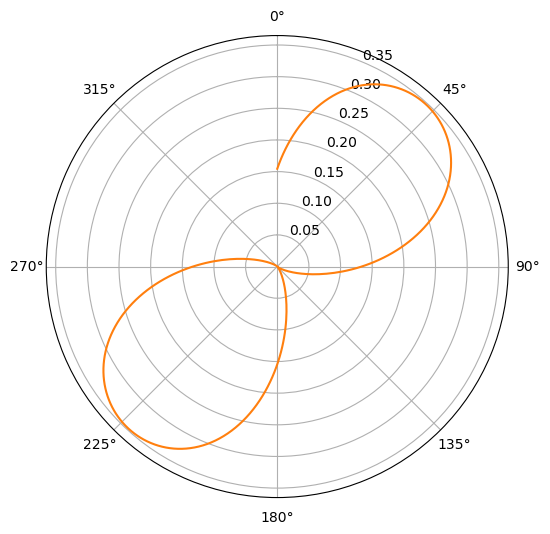

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6)) # make figure
colors = plt.cm.tab10.colors

primary_dir = primary_dir.copy()
primary_dir.index = pd.to_datetime(primary_dir.index)

all_diffs = []

for date, group in lo.groupby("date"):
    # flatten bearings
    bearings = np.concatenate(group["bearings"].values)
    bearings = bearings[np.isfinite(bearings)]
    if len(bearings) == 0:
        continue

    bearings_rad = np.radians(bearings % 180)

    date_ts = pd.to_datetime(date)
    if date_ts not in primary_dir.index:
        continue

    wind_angle_deg = primary_dir.loc[date_ts, "primary_wind_dir_deg"]
    if pd.isna(wind_angle_deg):
        continue
    wind_angle = np.radians(wind_angle_deg)

    
    # Compute signed angular difference
    diff = (bearings_rad - wind_angle) % np.pi  # axial wrap (0–π)

    # Reflect differences greater than 90° to their acute complement
    wind_diff = np.where(diff > np.pi / 2, np.pi - diff, diff)
    wind_diff = wind_diff[np.isfinite(wind_diff)]
    if len(wind_diff) == 0:
        continue

    wind_diff_axial = np.concatenate([wind_diff, wind_diff + np.pi])
    wind_diff_axial = wind_diff_axial[np.isfinite(wind_diff_axial)]
    if len(wind_diff_axial) > 0:
        all_diffs.append(wind_diff_axial)

# final concatenation
all_diffs = np.concatenate(all_diffs)
print(all_diffs)
print("Final array info:", all_diffs.shape, "NaNs:", np.isnan(all_diffs).sum())

kde = gaussian_kde(all_diffs)
theta = np.linspace(0, 2*np.pi, 360)
density = kde(theta)

ax.plot(theta, density, color=colors[i % len(colors)])

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.show()


Final array info: (2886,) NaNs: 0


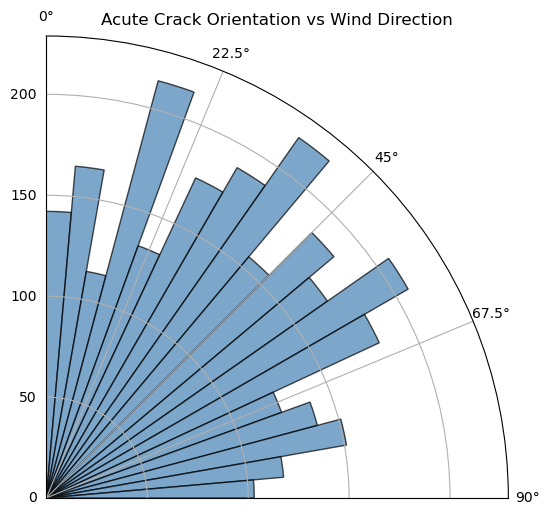

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
colors = plt.cm.tab10.colors

primary_dir = primary_dir.copy()
primary_dir.index = pd.to_datetime(primary_dir.index)

all_diffs = []

for date, group in lo.groupby("date"):
    # flatten bearings
    bearings = np.concatenate(group["bearings"].values)
    bearings = bearings[np.isfinite(bearings)]
    if len(bearings) == 0:
        continue

    bearings_rad = np.radians(bearings % 180)

    date_ts = pd.to_datetime(date)
    if date_ts not in primary_dir.index:
        continue

    wind_angle_deg = primary_dir.loc[date_ts, "primary_wind_dir_deg"]
    if pd.isna(wind_angle_deg):
        continue
    wind_angle = np.radians(wind_angle_deg)

    # Compute acute angular difference (0–π/2)
    diff = (bearings_rad - wind_angle) % np.pi
    wind_diff = np.where(diff > np.pi / 2, np.pi - diff, diff)
    wind_diff = wind_diff[np.isfinite(wind_diff)]
    if len(wind_diff) == 0:
        continue

    all_diffs.append(wind_diff)

# concatenate all angular differences
all_diffs = np.concatenate(all_diffs)
print("Final array info:", all_diffs.shape, "NaNs:", np.isnan(all_diffs).sum())

# --- Half-circle rose diagram ---
num_bins = 18  # change for finer/coarser resolution
bins = np.linspace(0, np.pi/2, num_bins + 1)
counts, edges = np.histogram(all_diffs, bins=bins)

# Convert bin centers to radians for plotting
theta = edges[:-1] + np.diff(edges)/2

# Plot as a polar bar chart (rose diagram)
ax.bar(theta, counts, width=np.diff(edges),
       bottom=0.0, color='steelblue', edgecolor='k', alpha=0.7)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_thetalim(0, np.pi/2)  # limit to 0–90° half circle
ax.set_title("Acute Crack Orientation vs Wind Direction", va='bottom')
ax.set_xticks(np.linspace(0, np.pi/2, 5))
ax.set_xticklabels(["0°", "22.5°", "45°", "67.5°", "90°"])
plt.show()
